# Problem 2

In [1]:
import wrds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [jonkq]:jonkq
Enter your password:········


#### 1)

In [3]:
amzn = db.raw_sql("select date, ret from crsp.dsf where permno in (84788) and date>='2010-01-01' and date<='2019-12-31'")
amzn.to_csv('amzn.csv')
mkt = db.raw_sql("select date, vwretd from crsp.dsi where date>='2010-01-01' and date<='2019-12-31'")
mkt.to_csv('mkt.csv')
rf = db.raw_sql("select caldt, tdyld from crsp.tfz_dly_rf2 where caldt>='2010-01-01' and caldt<='2019-12-31'")
rf.to_csv('rf.csv')

Data Cleaning

In [4]:
d1 = list(mkt['date'])
d2 = rf['caldt']
d2 = list(set(d2))
d2.sort()

In [5]:
# rf has multiple values for single dates -> take mean
rf = rf.set_index('caldt')
rf = [rf.loc[d2[i]].mean().item() for i in range(len(d2))]
rf = pd.DataFrame({'rf':rf, 'date':d2})
rf = rf.set_index('date')

In [6]:
# keep dates in d2 (and rf) that also are in d1
c2 = [d2[i] for i in range(len(d2)) if d2[i] in d1]
rf = rf.loc[c2]
# keep dates in d1 (amzn/mkt) that also are in c2 (rf)
d1 = [d1[i] for i in range(len(d1)) if d1[i] in d2]

In [7]:
# construct complete dataframe
data = amzn
mrkt = mkt.vwretd.squeeze()
data['mrkt'] = mrkt
data = data.set_index('date')
data = data.rename(columns={'ret':'amzn'})
data = data.loc[d1]
data['rf'] = rf.squeeze()

#### 2)

In [8]:
# Assuming one month contains 20 trading days, we use rolling windows of 120 observations (6 trading months)
# for the the rolling estimates

# compute excess returns for amzn and mrkt
excess = data.copy(deep=True)
excess.amzn -= excess.rf
excess.mrkt -= excess.rf

In [9]:
betas = []
alphas = []

for i in range(120,len(excess)):
    train = excess.iloc[(i-120):i,:]
    x = np.asarray(train.iloc[:,1]).reshape(-1,1)
    y = np.asarray(train.iloc[:,0]).reshape(-1,1)
    lm_fit = LinearRegression().fit(x, y)
    betas.append(lm_fit.coef_.item())
    alphas.append(lm_fit.intercept_.item())


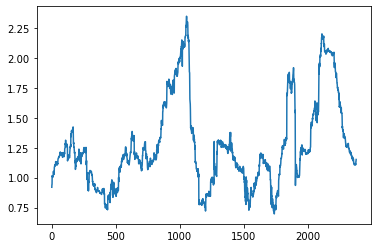

In [10]:
plt.plot(betas);

#### 3)

To simluate excess returns for AMZN that satisfies the CAPM, we create a series which corresponds to the estimated AMZN excess returns without alpha, which we get by multiplying the series of market excess returns by the average of the betas computed before. Then, we create the residuals series corresponding to observed AMZN excess returns and the ones just estimated. The variance of these residuals is simply an estimate of AMZN idiosyncratic variance under CAPM. We simulate a series of zero mean errors with the idiosyncratic variance just calculated, to which we add to the estimated excess AMZN excess returns, which yields a simulated series of excess returns with constant beta.

In [11]:
beta_avg = np.mean(betas)
est_excess = beta_avg * excess.mrkt
res = excess.amzn - est_excess
idio_risk = np.var(res)

In [12]:
errors = np.random.normal(scale=idio_risk, size=len(est_excess))
sim_excess = est_excess + errors

In [13]:
betas_sim = []

for i in range(120,len(excess)):
    train = excess.iloc[(i-120):i,:]
    x = np.asarray(train.iloc[:,1]).reshape(-1,1)
    y = np.asarray(sim_excess[(i-120):i,]).reshape(-1,1)
    lm_fit = LinearRegression().fit(x, y)
    betas_sim.append(lm_fit.coef_.item())

In [14]:
betas_sim = np.asarray(betas_sim)
adj_beta = 2/3*betas_sim + 1/3*beta_avg

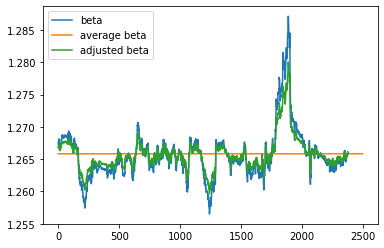

In [15]:
plt.plot(betas_sim, label = "beta")
plt.plot(np.full(len(est_excess),beta_avg), label = "average beta")
plt.plot(adj_beta, label = "adjusted beta")
plt.legend();

In [16]:
np.std(betas), np.std(betas_sim)

(0.3637592329743558, 0.00389114430641887)

We see that sampling variation significantly increases the rolling beta estimates' variance. Indeed, in part 2, the rolling estimated betas have a standard deviation of 0.36 whereas the rolling estimated betas using simulated excess returns based on a constant beta have a standard deviation of 0.0028.